# CSCE 479/879 Hackathon: Recurrent Models

Written by Eleanor Quint

Modified by Mrinal Rawool and Stephen Scott

Topics to be covered:
- Sentiment analysis using LSTM based network
- Sentiment analysis using LSTM + attention mechanism
- Introducing Transformers architecture
- Textual entailment classification using a pretrained Transformer model


In [1]:
# We'll start with our library imports...
from __future__ import print_function

import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops

DATA_DIR = './tensorflow-datasets/'

#### RNN/LSTM recap

Recurrent neural networks (RNNs) are computation graphs with loops (i.e., not directed acyclic graphs). Because the backpropagation algorithm only works with DAGs, we have to unroll the RNN through time. Tensorflow provides code that handles this automatically.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="80%">


The most common RNN unit is the LSTM, depicted below:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width="80%">

We can see that each unit takes 3 inputs and produces 3 outputs, two which are forwarded to the same unit at the next timestep and one true output, $h_t$ depicted coming out of the top of the cell.

The upper right output going to the next timestep is the cell state. It carries long-term information between cells, and is calculated as:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png" width="80%">

where the first term uses the forget gate $f_t$ to decide to scale the previous state (potentially making it smaller to "forget" it), and the second term is the product of the update gate $i_t$ and the state update $\tilde{C}_t$. Each of the forget and update gates are activated with sigmoid, so their range is (0,1).

The true output and the second, lower output on the diagram are calculated by the output gate:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png" width="80%">

First, $o_t$ is calculated from the output of the previous timestep concatenated with the current input, but then it's mixed with the cell state to get the true output. Passing on this output to the next timestep as the hidden state gives the unit a kind of short term memory.

(Images sourced from [Colah's Blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/))

### Tasks

#### Sentiment analysis task:

Sentiment Analysis is the task of classifying the polarity of a given text.

#### SNLI task

The Stanford Natural Language Inference (SNLI) corpus (version 1.0) is a collection of 570k human-written English sentence pairs manually labeled for balanced classification with the labels entailment, contradiction, and neutral. 

#### MNLI task

Multi-lingual Natural Language Inference (MNLI) is an extension of Natural Language Inference (NLI) task, also known as Recognizing Textual Entailment (RTE). Given two sentences, the task is to determine the inference relation between the texts. The relation has to be one of the three labels: entailment, contradiction, or neutral.

**Example**:

*Premise*: A black race car starts up in front of a crowd of people.

*Hypothesis*: A man is driving down a lonely road.

*Label*: **Contradiction**


#### Reference:

What is MNLI task?

https://cims.nyu.edu/~sbowman/multinli/

SNLI task:

https://nlp.stanford.edu/projects/snli/

Label associations:

0 = contradiction, 1 = entailment, 2 = neutral

### Demo: Sentiment Classification using LSTMs

Today, we're going to teach a recurrent model how to classify sentiment by inputting a sequence of words and asking the model to estimate what the sentiment is. The IMDB review dataset has the text of movie reviews and a label for whether the review is negative (zero) or positive (one). First, we'll load the dataset and then set up a preprocessor to turn the words into integers using `tf.keras.layers.experimental.preprocessing.TextVectorization`.

The workflow looks like this:

Raw text -> Vectorization/ Tokenization (word/ word-piece to int) -> Embeddings (int to embedding vector) -> Other model layers -> Model output layer -> Output

#### Step 1: Download and examine the dataset



In [2]:
# load the text dataset
ds = tfds.load('imdb_reviews', data_dir=DATA_DIR)
ds

2024-06-10 11:06:29.120609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2024-06-10 11:06:29.120642: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-10 11:06:29.120682: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c3619.swan.hcc.unl.edu): /proc/driver/nvidia/version does not exist
2024-06-10 11:06:29.160315: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


{'train': <PrefetchDataset shapes: {label: (), text: ()}, types: {label: tf.int64, text: tf.string}>,
 'test': <PrefetchDataset shapes: {label: (), text: ()}, types: {label: tf.int64, text: tf.string}>,
 'unsupervised': <PrefetchDataset shapes: {label: (), text: ()}, types: {label: tf.int64, text: tf.string}>}

In [3]:
ds_train = ds["train"].take(1)
for item in ds_train:
    print(item["text"], "\n", item["label"].numpy())

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string) 
 0


2024-06-10 11:06:31.958763: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2024-06-10 11:06:32.103588: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


#### Step 2: Create vectorization layer

to create a word <=> integer mapping


In [4]:
# vectorization hyperparams
MAX_SEQ_LEN = 128
MAX_TOKENS = 5000

# Create TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=MAX_TOKENS,
                                                    # standardize='lower_and_strip_punctuation',
                                                    # split='whitespace',
                                                    # ngrams=None,
                                                    # output_mode='int', # options: "int", "multi_hot", "count" or "tf_idf"
                                                    output_sequence_length=MAX_SEQ_LEN,
                                                    # pad_to_max_tokens=False,
                                                    # vocabulary=None,
                                                    # idf_weights=None,
                                                    # sparse=False,
                                                    # ragged=False,
                                                    # encoding='utf-8',
                                                    # **kwargs
                                                    )

 When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a vocabulary from them.

In [5]:
# Use `adapt` to create a vocabulary mapping words to integers
train_text = ds['train'].map(lambda x: x['text'])
vectorize_layer.adapt(train_text)


In [6]:
vectorize_layer.vocabulary_size() # due to max tokens limit

5000

In [7]:
vectorize_layer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (),
 'dtype': 'string',
 'max_tokens': 5000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 128,
 'pad_to_max_tokens': False}

In [8]:
print(vectorize_layer.get_vocabulary()[:10]) # most freq words
print(vectorize_layer.get_vocabulary()[-10:]) # least freq words

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']
['supported', 'stunned', 'spain', 'sid', 'rolled', 'rocky', 'popularity', 'pink', 'pamela', 'moronic']


#### Step 3: Apply Vectorization layer to a batch of the dataset


In [9]:
vectorize_output = vectorize_layer("This is an example.")

You might notice that the integer representation of each sentence ends in zeroes. To ensure that each input the same shape, the end of the sequence is padded with zeros. This is determined by MAX_SEQ_LEN and should typically be as long as the longest sequence in your dataset. The MAX_TOKENS value helps the TextVectorizer to pre-allocate a number of values to assign tokens to.

In [10]:
vectorize_output # padding because we have provided a max seq length

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([ 11,   7,  34, 454,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])>

In [11]:
# Let's print out a batch to see what it looks like in text and in integers
for batch in ds['train'].batch(1):
    text = batch['text']
    print(list(zip(text.numpy(), vectorize_layer(text).numpy())))
    break

[(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", array([  11,   14,   34,  412,  384,   18,   90,   28,    1,    8,   33,
       1322, 3560,   42,  487,    1,  191,   24,   85,  152,   19,   11,
        217,  316,   28,   65,  240,  214,    8,  489,   54,   65,   85,
        112,   96,   22,    1,   11,   93,  642,  743,   11,   18

#### The need for embedding layer


Now each word in the sequence is represented as an integer. However, this discrete representation fails to capture any semantic relationships between words. I.e., the model wouldn't know that "crimson" and "scarlet" are more similar than "red" and "blue". The solution is to learn an word embedding as the first part of the model to transform each integer into a relatively small, dense vector (as compared to a one-hot). Then, similar words will train to have similar embedded representations. A more sophisticated model might use a pre-trained word embedding like [BERT](https://blog.google/products/search/search-language-understanding-bert/).



#### Step 4: Create an Embedding layer

We'll use [tf.nn.embedding_lookup](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) to do this which we provide a trainable VOCAB_SIZE x EMBEDDING_SIZE matrix. This will learn an embedding from your dataset with training gradients.

A typical dictionary entry looks like
```
<word-idx> <word> = <a phrase that expresses its meaning>
```
This is implemented in two steps in NLP
1. **Tokenizer** assigns an index to each token or word ```<id> <token>```
2. **Embedding** assigns a numeric tensor (float) to each token ```<id> <n dimensional tensor>```

In [12]:
# embedding layer parameters
VOCAB_SIZE = len(vectorize_layer.get_vocabulary()) # eg 100
EMBEDDING_SIZE = int(np.sqrt(VOCAB_SIZE)) # 10 This ensures that the embedding matrix is dense
print("Vocab size is {} and is embedded into {} dimensions".format(VOCAB_SIZE, EMBEDDING_SIZE))

embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_SIZE)

Vocab size is 5000 and is embedded into 70 dimensions


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sample_text = "This is an example"
vectorized_text = vectorize_layer(sample_text)
embedding_text = embedding_layer(vectorized_text)
print(embedding_text.shape) # (128, 70) 128 is the MAX_SEQ_LEN

(128, 70)


In [14]:
id_token_map = vectorize_layer.get_vocabulary()
len(id_token_map)

5000

In [15]:
ytick_labels = [id_token_map[id] for id in vectorized_text[:6]]
ytick_labels

['this', 'is', 'an', 'example', '', '']

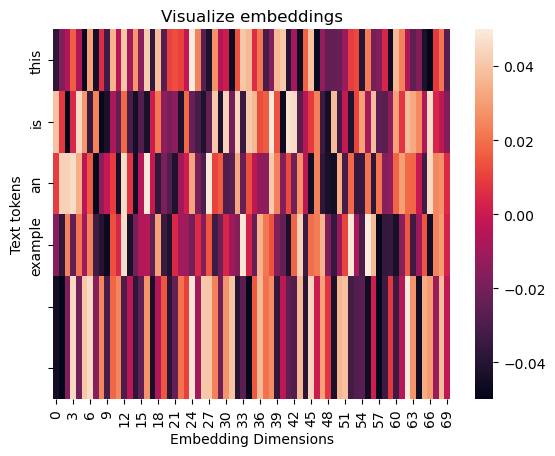

In [16]:

ax = sns.heatmap(embedding_text[:6], yticklabels=ytick_labels) # first 6 tokens

ax.set(xlabel ="Embedding Dimensions", ylabel = "Text tokens", title ="Visualize embeddings")
plt.show()


#### A brief note on how Recurrent network APIs are implemented in TF

[Tensorflow RNNs](https://www.tensorflow.org/guide/keras/working_with_rnns)

RNN layers ([keras.layers.SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) | [keras.layers.GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) | [keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)) 

v/s 

RNN Cells ([tf.keras.layers.SimpleRNNCell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNNCell) | [tf.keras.layers.GRUCell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRUCell) | [tf.keras.layers.LSTMCell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell))

Layers can process batches of input sequences.

Cells processes a single timestep.

Mathematically, RNN(LSTMCell(10)) produces the same result as LSTM(10). However using the built-in GRU and LSTM layers enable the use of CuDNN and you may see better performance.


In [30]:
# Example 1: using a cell instance
inputs = np.random.random((32, 10, 8))
# tf.keras.layers.RNN is a wrapper that allows customization of what happens inside the RNN layer
# tf.keras.layers.RNN can be instantiated using a RNN cell instance or a list of RNN cell instances.
rnn = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(4)) # 4 is the output dimension of LSTM cell
output = rnn(inputs)
output.shape

TensorShape([32, 4])

In [31]:
# Example 2: Using a list of cells
inputs = np.random.random((32, 10, 8))
# tf.keras.layers.RNN can be instantiated using a RNN cell instance or a list of RNN cell instances.
rnn = tf.keras.layers.RNN([tf.keras.layers.LSTMCell(256), tf.keras.layers.LSTMCell(64)])
output = rnn(inputs)
output.shape

TensorShape([32, 64])

When RNN layer is created as above, i.e by passing a list of LSTM cell instances, a [stacked RNN layer](https://github.com/keras-team/keras/blob/v3.3.3/keras/src/layers/rnn/rnn.py) (StackedRNNCells‎) gets created. A stacked RNN has multiple hidden layers allowing them to abstract more information from the input at each time step and pass it on to the next layer. For a timestep `t`, a layer `L` calculates its hidden state `h(t)(L)` using its input, previous hidden state `h(t-1)(L)`. The next layer `L+1` calculates its hidden state `h(t)(L+1)` using its input `h(t)(L)` (Note that this is the hidden state of the previous layer of the RNN stack), and its own previous hidden state `h(t-1)(L+1)`.

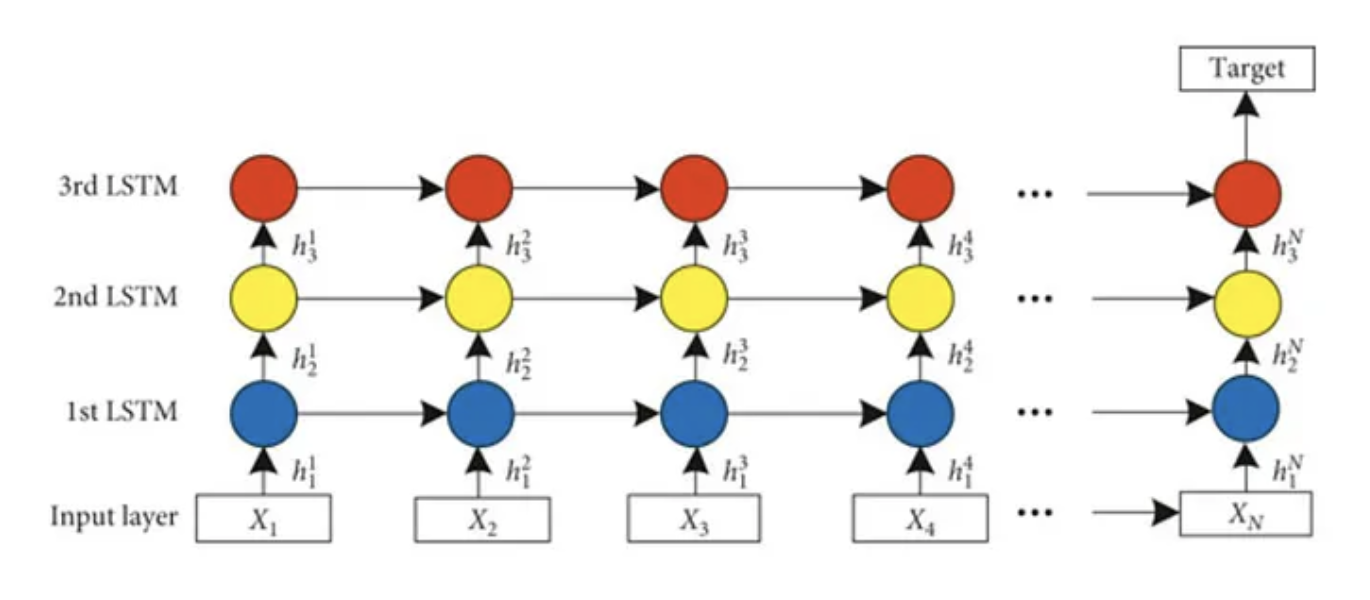


Image courtesy [this article](https://python.plainenglish.io/stacked-rnns-in-nlp-936e6eecf37a)

#### Step 5: Building a classifier model using Recurrent layer

TensorFlow separates the declaration of RNNCells from the [RNNs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN) that run them. In the code below, we declare two [LSTM cells](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell) and pass them both to the RNN to be run together.

In [32]:
# Build the model

# We create a list of LSTM cell instances with output dim 256 and 64. 
# Then we use an RNN layer wrapper around these LSTM cells. This allows the model to process batches of input sequences.
# The below line of code creates two LSTM cells (capable of processing a timestep)
cells = [tf.keras.layers.LSTMCell(256), tf.keras.layers.LSTMCell(64)]
# we then wrap the cells inside an RNN layer which is capable of processing an input sequence.
rnn = tf.keras.layers.RNN(cells) 
# finally, we use a dense layer as the output layer
output_layer = tf.keras.layers.Dense(2)

model = tf.keras.Sequential([vectorize_layer, embedding_layer, rnn, output_layer])

# _ = model(["sample input"])
text = tf.constant(["sample input"])
_ = model(text)
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 128)               0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 70)           350000    
_________________________________________________________________
rnn_12 (RNN)                 (None, 64)                417024    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 130       
Total params: 767,154
Trainable params: 767,154
Non-trainable params: 0
_________________________________________________________________


In [33]:
# test a forward pass
for batch in ds['train'].batch(2):
    print(batch['text'])
    print("===========")
    logits = model(batch['text']) # output layer will yeild logits i.e raw probabilities
    print("Batch      :", batch['text'].shape)
    print("Batch label:", batch['label'].shape)
    print("===========")
    print("Vectorize  :", vectorize_layer(batch['text']).shape)
    print("Embedding  :", embedding_layer(vectorize_layer(batch['text'])).shape)
    print("Recurrent  :", rnn(embedding_layer(vectorize_layer(batch['text']))).shape)
    print("Dense (out):", output_layer(rnn(embedding_layer(vectorize_layer(batch['text'])))).shape)
    print("===========")
    print("Logits     :", logits.numpy())
    print("Probas     :", tf.nn.softmax(logits).numpy())
    print("Predictions:", np.argmax(tf.nn.softmax(logits), axis=-1))
    print("True label :", batch['label'].numpy())

    loss = tf.keras.losses.binary_crossentropy(tf.one_hot(batch['label'], 2, axis=-1), logits, from_logits=True)
    print("BCE loss   :", loss)

    break

tf.Tensor(
[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot de

Then, to do sentiment analysis, we'll treat this as a classification problem. Because it's only a 2-class problem, we'll use binary cross-entropy and output only one value. Then the output is treated as class zero if it's $<0.5$ and class one if it's $\geq0.5$. We can train this model in the usual way.



### Sentiment analysis using Attention mechanism and LSTMs

One way to enhance the performance of sequential models is a mechanism called attention. Essentially, the idea is that in order to process the meaning of a token correctly, it might rely on tokens far away in the sequence. We're going to use Luong-style attention, which is a classic variety first employed in language translation. It's implemented by `tf.keras.layers.Attention`.

#### Block diagram of the network using attention mechanism

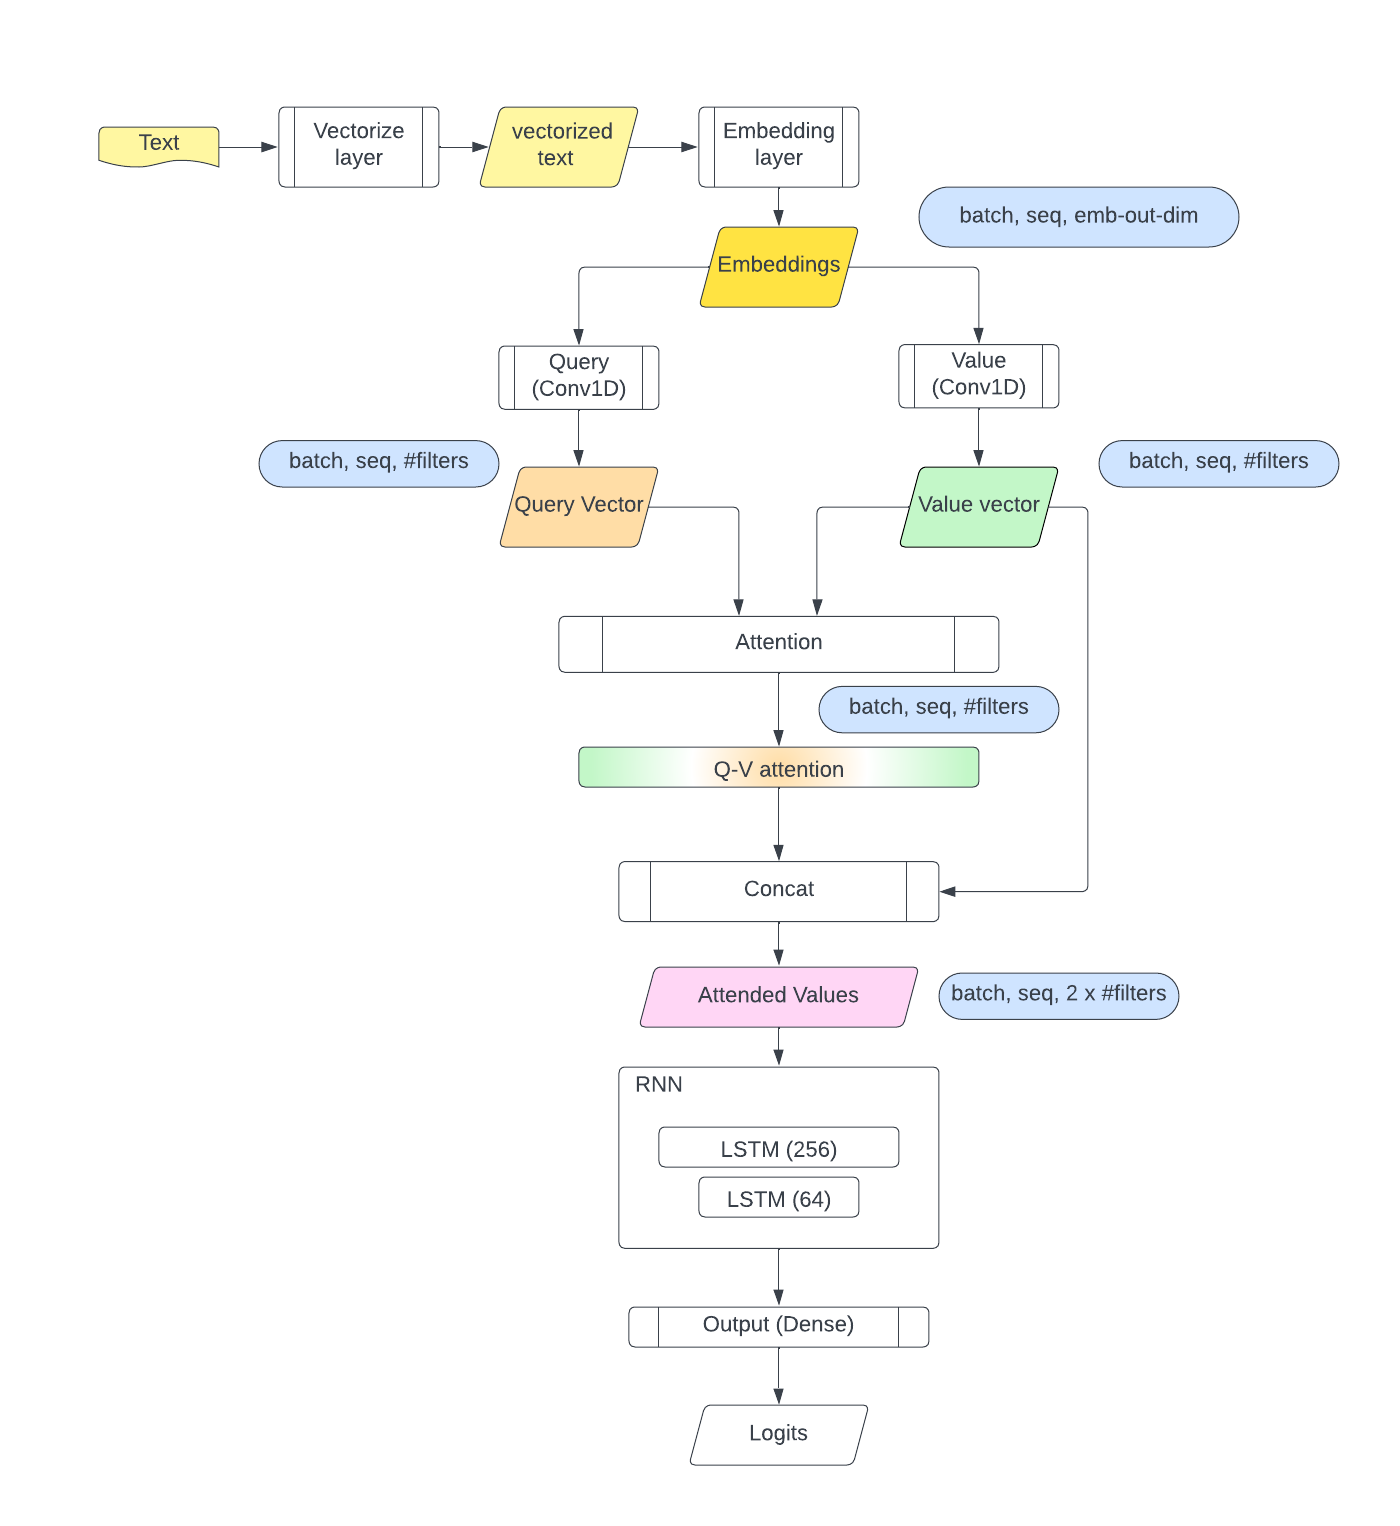

#### Build the model

In [38]:
# We'll make a conv layer to produce the query and value tensors
query_layer = tf.keras.layers.Conv1D(
    filters=100,
    kernel_size=4,
    padding='same')
value_layer = tf.keras.layers.Conv1D(
    filters=100,
    kernel_size=4,
    padding='same')
# Then they will be input to the Attention layer
attention = tf.keras.layers.Attention()
concat = tf.keras.layers.Concatenate()

cells = [tf.keras.layers.LSTMCell(256), tf.keras.layers.LSTMCell(64)]
rnn = tf.keras.layers.RNN(cells)
output_layer = tf.keras.layers.Dense(1)


In [39]:
for batch in ds['train'].batch(1):
    print(batch['text'])
    print("===========")
    text = batch['text']
    embeddings = embedding_layer(vectorize_layer(text))
    print("Embedding: ", embeddings.shape)
    query = query_layer(embeddings)
    print("Query: ", query.shape)
    value = value_layer(embeddings)
    print("Value: ", value.shape)
    # Checkout the note below to understand how attention scores are calculated.
    query_value_attention = attention([query, value]) # list of tensors. 
    print("Shape after attention: ", query_value_attention.shape)
    attended_values = concat([query, query_value_attention])
    print("Shape after concatenating: ", attended_values.shape)
    logits = output_layer(rnn(attended_values))
    loss = tf.keras.losses.binary_crossentropy(tf.expand_dims(batch['label'], -1), logits, from_logits=True)
    print("Loss: ", loss)
    break

tf.Tensor([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."], shape=(1,), dtype=string)
Embedding:  (1, 128, 70)
Query:  (1, 128, 100)
Value:  (1, 128, 100)
Shape after attention:  (1, 128, 100)
Shape after concatenating:  (1, 128, 200)
Loss:  tf.Tensor([0.69556314], shape=(1,), dtype=float32)


#### Stepping into calculating attention vector

A brief note on how attentions are calculated using [tf.keras.layers.Attention()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention)

Inputs are
1. query tensor of shape [batch_size (1), Tq (128), dim (70)],
2. value tensor of shape [batch_size (1), Tv (128), dim (70)] and
3. key tensor of shape [batch_size, Tv, dim] (same as query in this case). The calculation follows the steps:

Calculate
1. **scores** with shape [batch_size, Tq, Tv] as a query-key dot product: scores = tf.matmul(query, key, transpose_b=True).=> ```(128 x 70) (70 x 128) => 128 x 128``` and
```scores.shape = (1, 128, 128)```

2. Use scores to calculate a **distribution** with shape [batch_size, Tq, Tv]: distribution = tf.nn.softmax(scores).
```distribution.shape = (1, 128, 128)```

3. Use distribution to create a linear combination of value with shape [batch_size, Tq, dim]: return tf.matmul(distribution, value).
``` distribution.shape = (1, 128, 128)```

4. value.shape = (1, 128, 70) # value are the weights in the scaled dot product matmul((128, 128), (128, 70)) => 128 x 70


In this way we can produce a very similar RNN over a sequence, but incorporate more dynamic relationships betweeen distant tokens.


### 

Thus far, we have learnt how to perform sentiment analysis task which is a NLP classification task using the IMDb dataset and a model built using Tensorflow APIs. While Tensorflow has extensive documentation on how to create models capable of handling different types of NLP tasks, it is worthwhile to look at another popular and widely used library called the [Transformers library by HuggingFace](https://huggingface.co/docs/transformers/en/index). This library provides APIs and tools to easily download and train state-of-the-art pretrained models. Using pretrained models can reduce your compute costs, carbon footprint, and save you the time and resources required to train a model from scratch. These models support common tasks in different modalities, such as NLP, Computer Vision, Audio. Transformers library also supports framework interoperability between PyTorch, TensorFlow, and JAX.

In the next few sections, we will look at the Transformers architecture followed by a quick demo of the Natural Language Inference (NLI) task using [DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert), a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than google-bert/bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the [GLUE language understanding benchmark](https://gluebenchmark.com).

### The Transformer Architecture

A Transformer Block from [this](https://arxiv.org/pdf/1706.03762.pdf) paper

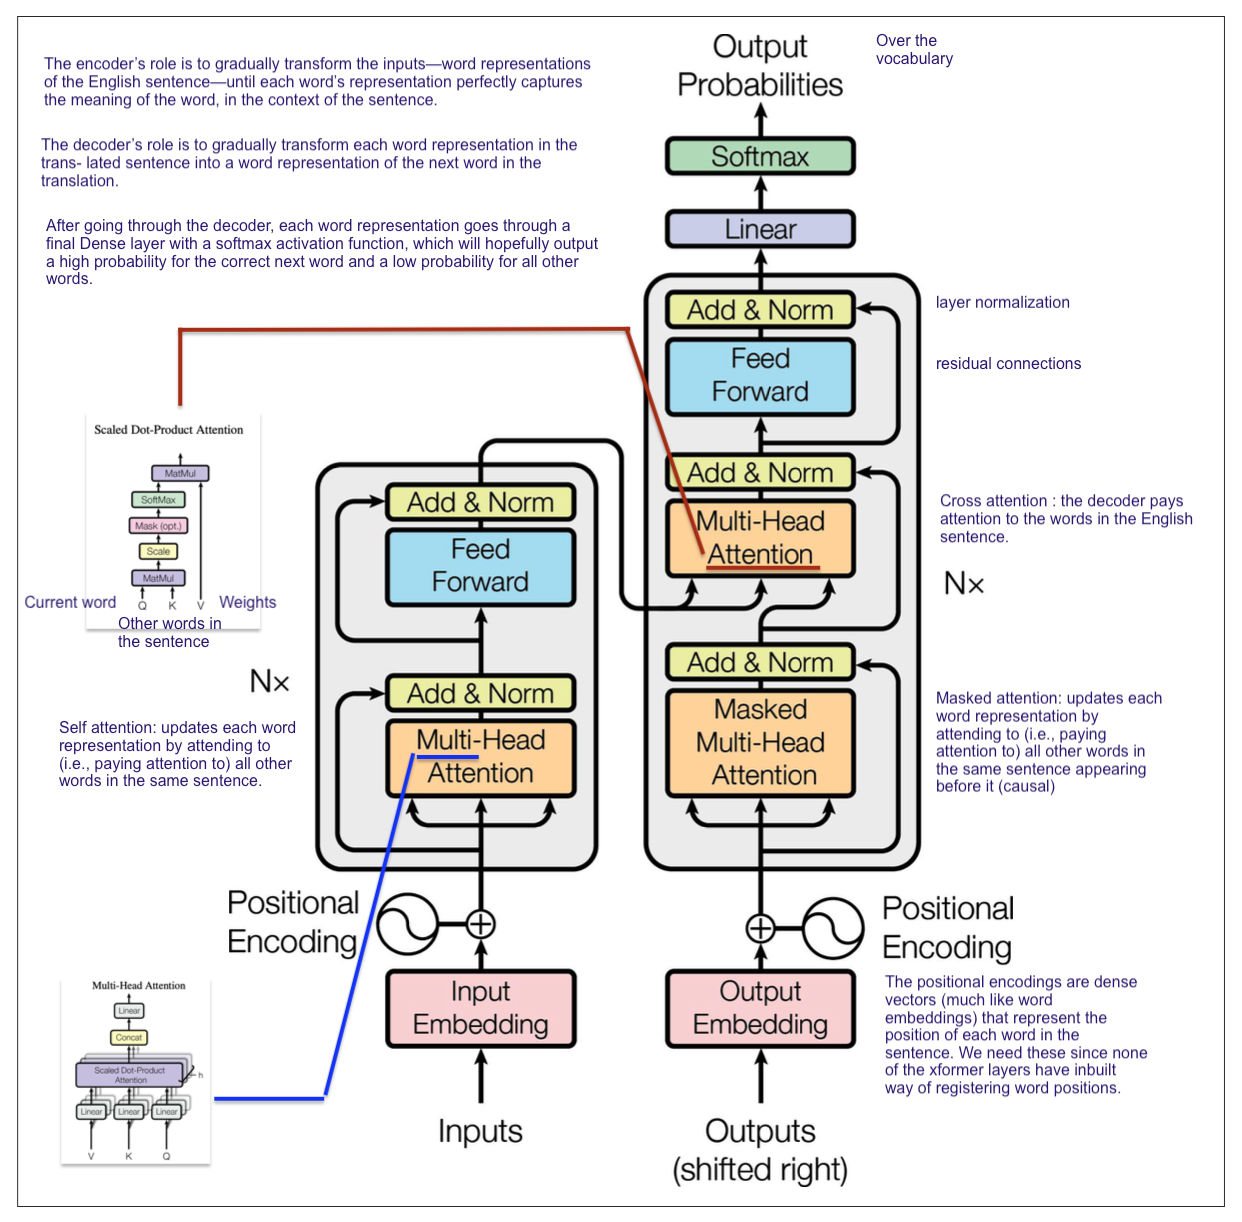

Since models based on Transformer architecture are inherently large, it is a common practice to use pre-trained models from a suitable checkpoint, and finetune it for a desired task. Let's take Distilbert as an example. Generally, the model network consists of

1. Pre-processing layers: These may be part of the model or could be added separately based on the checkpoint being used.
2. Main model layers: This layer group generally starts with input_ids, attention_masks, and token_type_ids (optional) and ends with Attention outputs and pooler outputs that can be consumed by the task oriented layers for prediction or classification.
3. Task oriented layers: These may be part of the model or could be added separately based on the checkpoint being used.

### Demo: Using DistilBert

You can check out [this Github repository](https://github.com/huggingface/transformers/tree/main/examples/research_projects/distillation) for more information on DistilBert

As mentioned before, a model can be made available with or without task heads or language modelling heads. Let's look at two variations of DistiBert to understand this.

HuggingFace offers two checkpoints. The checkpoint "distilbert-base-uncased" is used to access DistilBert base model while chekpoint "huggingface/distilbert-base-uncased-finetuned-mnli" can be used to access DistilBert finetuned for the MNLI task.

A task head is a layer or group of layers stacked on top of the base model to train it for a specific task. In the next sub section, we will be using the base model i.e DistilBERT model with its base architecture. Since we are interested in a Tensorflow model, we will be accessing an available model checkpoint using the from_pretrained() method of the TFDistilBertModel module from the Transformers library. Furthermore, when we wish to access a task-specific model, such as a DistilBERT model finetuned on NLI task, we will be using the from_pretrained() of the TFAutoModelForSequenceClassification module.

For the tokenizer, we will be using the from_pretrained() of the AutoTokenizer class. This class instantiates one of the tokenizer classes of the library from a pretrained model vocabulary. The instance to be generated is controoled by the pretrained_model_name_or_path argument which is "distilbert-base-uncased" for the base model and "huggingface/distilbert-base-uncased-finetuned-mnli" for the task specific model. Every model in HuggingFace comes with its own tokenizer to ensure that the inputs are processed correctly.

#### no task head

In [19]:
from transformers import AutoTokenizer, TFDistilBertModel
import tensorflow as tf

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
base_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

2024-05-31 05:08:46.914577: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the 

In [20]:
base_model.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


In [23]:
base_model.config # compare with the config of finetuned model

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.6.1",
  "vocab_size": 30522
}

In [24]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
print("Tokenized inputs are: ", tokenizer.convert_ids_to_tokens(inputs.input_ids[0]))
outputs = base_model(inputs,
                     output_attentions=True,
                     output_hidden_states=True
                     )
outputs.keys()

Tokenized inputs are:  ['[CLS]', 'hello', ',', 'my', 'dog', 'is', 'cute', '[SEP]']


odict_keys(['last_hidden_state', 'hidden_states', 'attentions'])

In [25]:
inputs = tokenizer([("Sky is blue", "Sky is red")], return_tensors="tf")
print("Tokenized inputs are: ", tokenizer.convert_ids_to_tokens(inputs.input_ids[0]))
outputs = base_model(inputs,
                     output_attentions=True,
                     output_hidden_states=True
                     )
outputs.keys()

Tokenized inputs are:  ['[CLS]', 'sky', 'is', 'blue', '[SEP]', 'sky', 'is', 'red', '[SEP]']


odict_keys(['last_hidden_state', 'hidden_states', 'attentions'])

#### Fine-tuning using a task-oriented pre-trained model

In [26]:
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"

In [28]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
# Note: "TFAutoModelForSequenceClassification" Instantiates one of the model classes of the library
# (with a sequence classification head) from a configuration.

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

Some layers from the model checkpoint at huggingface/distilbert-base-uncased-finetuned-mnli were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at huggingface/distilbert-base-uncased-finetuned-mnli and are newly initialized: ['dropout_58']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
model.config

DistilBertConfig {
  "_name_or_path": "huggingface/distilbert-base-uncased-finetuned-mnli",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "dim": 768,
  "dropout": 0.1,
  "eos_token_ids": 0,
  "finetuning_task": "mnli",
  "hidden_dim": 3072,
  "id2label": {
    "0": "contradiction",
    "1": "entailment",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "label2id": {
    "contradiction": "0",
    "entailment": "1",
    "neutral": "2"
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.6.1",
  "vocab_size": 30522
}

In [31]:
sentences = [("Sky is blue", "Sky is red"), ("I love her", "She loves me")]
X_train = tokenizer(sentences, padding=True, return_tensors="tf").data
y_train = tf.constant([0, 2])  # contradiction, neutral
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


1/1 [==============================] - 12s 12s/step - loss: 1.1287 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 219ms/step - loss: 0.0941 - accuracy: 1.0000


In [32]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  2307      
_________________________________________________________________
dropout_58 (Dropout)         multiple                  0         
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________


### Visualizing Attention Layers with DistilBert

If you observe the model configuration, DistilBert has 

"n_heads": 12 

"n_layers": 6

A quick comparison with the Transformer architecture diagram reveals that there is an attention sub-layer for each layer. Since DistilBert is a relatively smaller model, it has 6 layers, therefore, 6 attention layers with 12 attention heads per layer. In this section, we will look at one attention layer for an arbitarily chosen sample. We will then use a heatmap to visualize the chosen attention layer.

In [33]:
token_ids = tokenizer(["I like soccer. [SEP] We all love soccer!",
                       "Joe lived for a very long time. [SEP] Joe is old."],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [34]:
print(tokenizer.convert_ids_to_tokens(token_ids.input_ids[0]))

['[CLS]', 'i', 'like', 'soccer', '.', '[SEP]', 'we', 'all', 'love', 'soccer', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]']


Here, we do not add the [SEP] special token to seperate the two sentences. However, the tokenizer takes care of inserting the required special tokens.

In [35]:
token_ids = tokenizer([("I like soccer.", "We all love soccer!"),
                       ("Joe lived for a very long time.", "Joe is old.")],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [36]:
print(tokenizer.convert_ids_to_tokens(token_ids.input_ids[0]))

['[CLS]', 'i', 'like', 'soccer', '.', '[SEP]', 'we', 'all', 'love', 'soccer', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]']


When return_dict = False, the output is returned as a tensor containing three elements (logits, hidden_states, attentions) per input.

In [37]:
outputs = model(**token_ids, return_dict=False)
outputs

(<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[-3.2162135, -1.4901024,  4.7289677],
        [-3.450566 , -1.6998006,  5.17841  ]], dtype=float32)>,)

In [38]:
outputs = model(**token_ids, return_dict=True, output_attentions=True, output_hidden_states=True)
outputs.keys()
# Note the difference in the output of the model with and without task head
# base model output         : odict_keys(['last_hidden_state', 'hidden_states', 'attentions'])
# task-oriented model output: odict_keys(['logits', 'hidden_states', 'attentions'])

odict_keys(['logits', 'hidden_states', 'attentions'])

In [39]:
len(outputs["attentions"])
#  "n_heads": 12,
#  "n_layers": 6,
# every encoder or decoder layer has an attention sub-layer (refer fig above)

6

In [40]:
outputs["attentions"][0].shape # batch, heads, seq, seq

TensorShape([2, 12, 15, 15])

In [41]:
attentions=outputs["attentions"][0][0, :, :, :] # one layer, one input (sentence pair)
attentions.shape

TensorShape([12, 15, 15])

In the below plot, we visualize attention layer values for one of the layer and one sample input. Since each attention layer has 12 attention heads, we have 12 heatmaps. You can change the layer number (0-5) to check out how attentions for other layers look like.

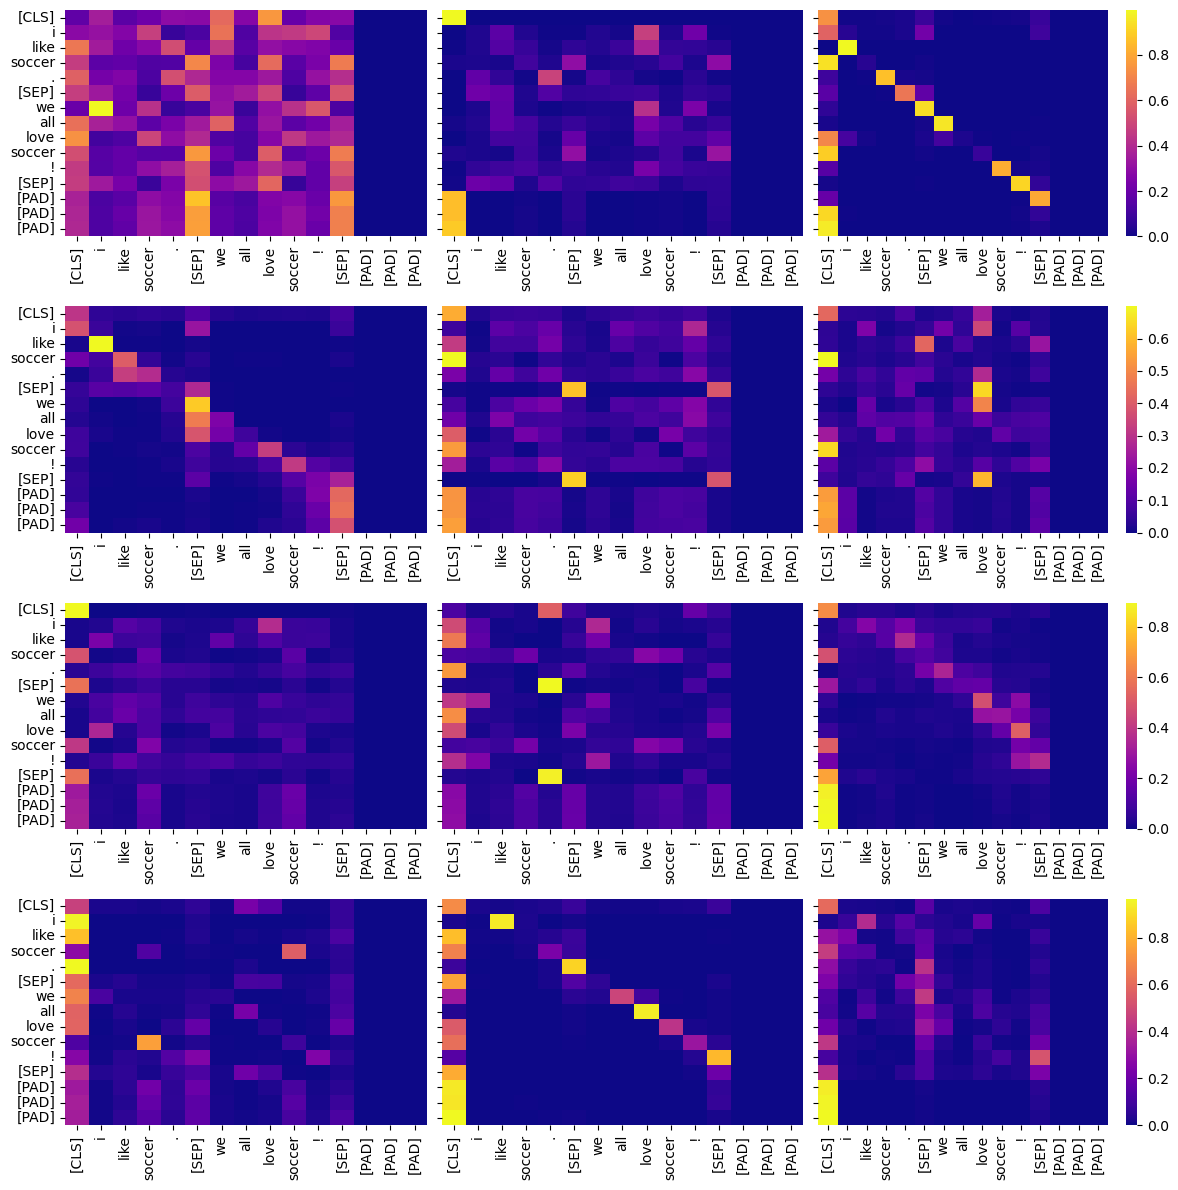

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# visualizing first sample, all attention heads of layer 0 of the encoder
layer_num=0
attentions=outputs["attentions"][layer_num][0, :, :, :] # layer0, input-sample 0
attentions.shape

plt.rcParams["figure.figsize"] = [12, 12]
plt.rcParams["figure.autolayout"] = True


fig, ax = plt.subplots(nrows=4, ncols=3, sharey=True) # 12 = 6x2
fig.subplots_adjust(wspace=0.01)

tick_labels = tokenizer.convert_ids_to_tokens(token_ids.input_ids[0])

i=0
for r in range(4):
    for c in range(3):

        cbar=True if c==2 else False

        sns.heatmap(attentions[i],
                    xticklabels=tick_labels,
                    yticklabels=tick_labels,
                    cmap="plasma",
                    ax=ax[r][c],
                    cbar=cbar)
        i+=1

fig.subplots_adjust(wspace=0.001)
fig.tight_layout()
plt.show()

In [43]:
Y_probas = tf.keras.activations.softmax(outputs.logits)
Y_probas

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.5353660e-04, 1.9864370e-03, 9.9766004e-01],
       [1.7863179e-04, 1.0287419e-03, 9.9879265e-01]], dtype=float32)>

In [45]:
Y_pred = tf.argmax(Y_probas, axis=1)
Y_pred  # 0 = contradiction, 1 = entailment, 2 = neutral

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 2])>

## Helpful links and references

"Attention is all you need"
https://arxiv.org/pdf/1706.03762.pdf

BERT: https://arxiv.org/pdf/1810.04805.pdf

The Illustrated Transformer Blog: http://jalammar.github.io/illustrated-transformer/

# Homework

For this homework, please use the notebook "h6-hw6-template-code.ipynb". This notebook contains the starter code that you'll need for completing the homework assignment.

You will be using the [SNLI](https://huggingface.co/datasets/stanfordnlp/snli) dataset to finetune the MNLI checkpointed DistilBert model used in this notebook. The goal is to compare attentions for a sample with and without finetuning. 

Some lines of code are incomplete. Please refer to the code prior to the homework section (especially the section titled "Fine-tuning using a task-oriented pre-trained model") for hints and reference code. Feel free to experiment with the provided code and observe which parameter combinations lead to better model training.